### 1. 다양한 시계열 예측 기법 비교
1. SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)
- ARIMA의 확장
- seasonal, non-seasonal data 처리 가능
- X변수 적용 가능
- 중소규모 데이터에 적절
- 모형 파라미터 해석 및 계절적 패턴이 분명할 경우 모델링 성능 우수
- Careful parameter tuning (e.g., p, d, q, P, D, Q).
- Linear relationships 가정: 대규모 데이터 및 비선형 트렌드에서는 성능 저하

2. RNN (Recurrent Neural Networks)
- neural network: 순차적인 데이터를 처리(기존 입력값에 대한 memory), 시계열에 활용
- temporal dependencies를 활용
- univariate & multivariate time series에 활용
- 비선형 패턴/복잡한 패턴 모델링
- long-term dependency : vanishing gradient problems
- 통계 모형 대비 해석이 어려움





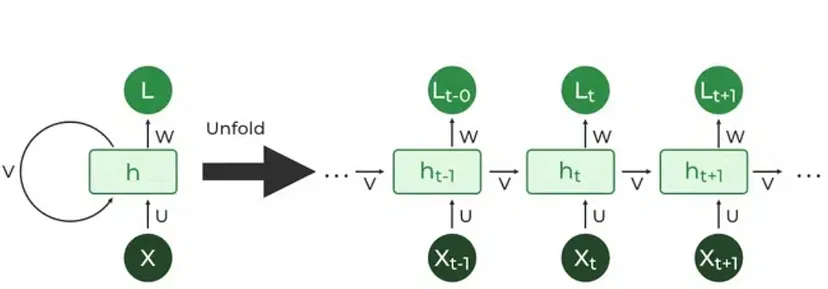

3. LSTM (Long Short-Term Memory Networks)
LSTM networks are a variant of RNNs designed to overcome the vanishing gradient problem, making them more effective at learning long-term dependencies in time series data.

LSTMs are widely used in fields like finance (stock price prediction), healthcare (patient monitoring), and any scenario involving sequential data with complex patterns.

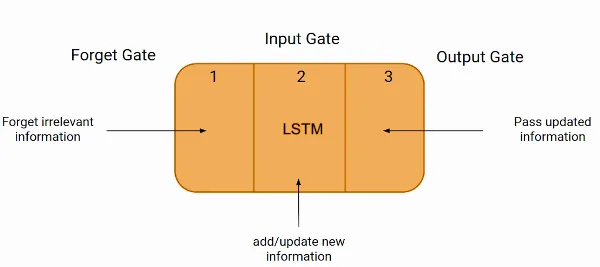

- memory cell을 통해서 long sequence에 대한 정보를 유지
- noisy data, long term dependency 처리
- 다른 모형과 같이 사용
- 계산 비용
- 데이터가 많아야 피팅이 좋음

4. Prophet
- open-source forecasting tool developed by Facebook
- 결측, 이상치, 계절성이 강한 시계열 데이터에 활용
- 사용이 편하며, 파라미터 튜닝이 필요없음
- 비즈니스 예측 등에 많이 활용: 소매 판매, 웹트래픽 등

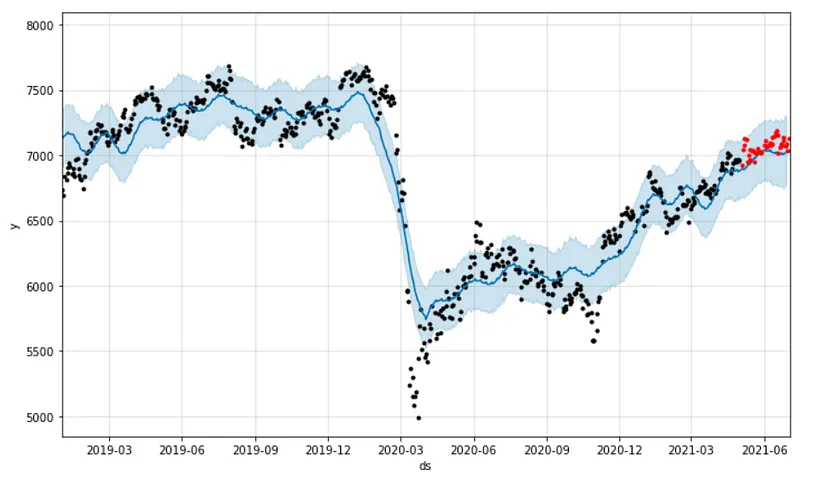

- 자동으로 결측 및 이상치 처리
- 일별/주별/연간 계절성 처리
- 사용이 편리
- 계절성 외 비선형 패턴 처리에 약함

5. Transformer Models
- Transformer models: suquential data 처리가 우수하여 시계열 예측에 적용
 - self-attention mechanisms: 입력 sequence의 각각 다른 파트에 집중
 - energy load forecasting, anomaly detection, other applications에 활용
 - 우수한 성능 및 sequence의 dependency를 잘 처리.

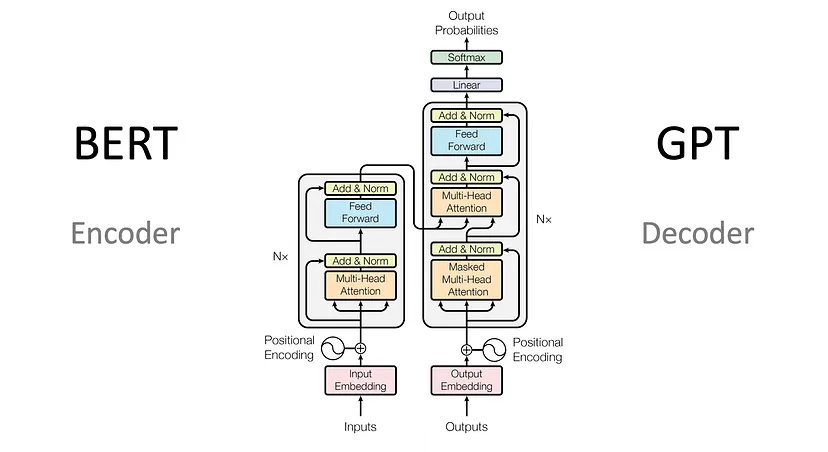

- Self-attention: sequential한 각 값에 다른 가중치를 적용.
- 병렬 처리를 통한 빠른 학습 / long-term dependencies
- 비선형/선형 패턴 모델링
- 작은 데이터인 경우 과적합의 문제 / 해석의 어려움

### Transformer 사용: TimesFM (Foundation Model)
- TimesFM : decoder-only transformer
- Patched-Decoder Style
 - NLP의 토큰 대신 Patch 사용: TimesLM은 시계열 데이터를 patch 단위로 나눔
 - patch: 시계열 값들의 세그먼트, 각 patch가 토큰의 역할
 - 1024개 값의 시계열이 32개 길이의 패치로 나눠질 수 있음, 32개 패치를 처리
 - 토큰의 수를 Transformer 은닉층으로 줄이며 계산

- Flexible Input and Output Patch Lengths
 - Input patches로 입력 시계열의 context를 파악, output patch로는 미래 값을 예측
 - 긴 미래 시점의 값을 예측할 수 있음(예: 128개 값의 예측)
 - 일반화 전략: random masking during training, 패치에 대한 drop out과 같으며, 다양한 context 길이에 모형의 적응력을 높임

- Stacked Transformer Layers
 - self-attention and feedforward networks의 조합
 - causal attention을 통해서 과거 데이터에 의존한 미래 패치의 값을 예측

- 시계열 처리
 - Positional encoding: temporal적인 면을 인식, 시계열 데이터 처리를 지원

- 학습: data diveristy, efficient Processing
 - 다양한 데이터로 미리 학습: 현실 데이터와 현실 데이터 합성을 통해 다양성
 - Google Trends, Wiki Pageviews, Synthetic Data(ARMA processes, seasonal patterns,  step functions 등 포함)

 - Patched Input Processing: 시계열 데이터가 non-overlapping patches로 나눠지며, 각 패치는 임베딩으로 변환
 - Masking During Training: 다양한 context 길이를 지원하기 위한 랜덤 마스킹
 - Loss Function: MSE

- Dataset Mixing Strategy
 - 50–50 split between real and synthetic data.
 - 실제 데이터에 대해서는 가중치가 일별/주별/월별 데이터셋에 동일하게 적용

- zero-shot forecasting ability
 — 학습하지 않았던 데이터에 대해 좋은 성능이 나옴

- Scaling Laws
 - model size, data volume, training compute에 영향
 - NLP와 같이, parameter count와 forecasting accuracy 관계가 있음
 - 예: 17M, 70M, 200M parameters로 학습 시 결과가 지속적으로 개선


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
absl_logger = logging.getLogger("absl")
cmdstanpy_logger.disabled = True
absl_logger.disabled = True

In [3]:
# Data loading
temps = pd.read_csv('daily-min-temperatures.csv')

In [4]:
# Conversion of date to datetime format
temps['ds'] = pd.to_datetime(temps['Date'])
temps.drop(columns=['Date'], inplace=True)
temps.rename(columns={'Temp': 'y'},inplace=True)

In [5]:
temps['y'].astype("str").str.replace("?", "0").astype(float)
temps.head()

,y,ds
0,20.7,1981-01-01
1,17.9,1981-01-02
2,18.8,1981-01-03
3,14.6,1981-01-04
4,15.8,1981-01-05


In [6]:
# Plotting the evolution of the temperature
fig = px.line(temps, x='ds', y='y')
fig.update_layout(
    title='Evolution of the temperature',
    xaxis_title='Date',
    yaxis_title='Temperature'
)

In [7]:
temps['y'].describe()

,y
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [8]:
nb_missing_timestamps = len(pd.date_range( start=temps['ds'].min(), end=temps['ds'].max()).difference(temps.ds))
print(str(nb_missing_timestamps) + ' missings timestamps')

2 missings timestamps


In [9]:
missing_dates = pd.date_range(start=temps['ds'].min(), end=temps['ds'].max(), freq='D').difference(temps['ds'])
missing_data = {'ds': missing_dates, 'y': [pd.NA]*len(missing_dates)}
missing_df = pd.DataFrame(missing_data)

temps = pd.concat([temps, missing_df]).sort_values(by='ds').reset_index(drop=True)
temps['y'] = temps['y'].fillna(method='ffill')

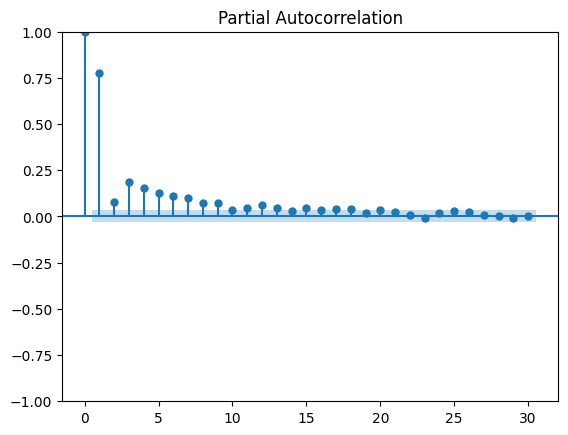

In [10]:
plot_pacf(temps.y,lags = 30);

In [11]:
# Add of the week of the day and the month of the year information
temps['weekday'] = temps['ds'].dt.weekday
temps['month'] = temps['ds'].dt.month

<Axes: xlabel='weekday', ylabel='y'>

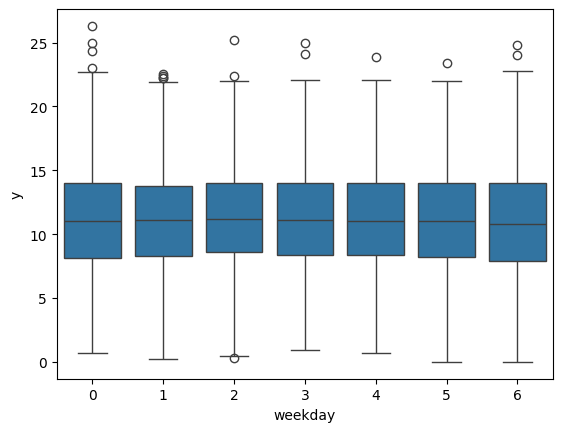

In [12]:
sns.boxplot(x="weekday", y="y", data=temps)

<Axes: xlabel='month', ylabel='y'>

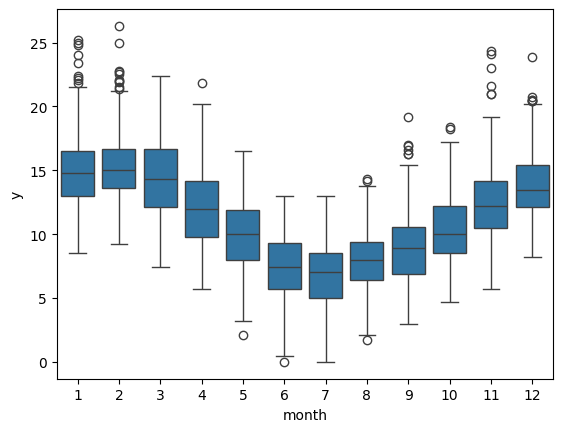

In [13]:
sns.boxplot(x="month", y="y", data=temps)

In [14]:
temps.shape
temps.head()

,y,ds,weekday,month
0,20.7,1981-01-01,3,1
1,17.9,1981-01-02,4,1
2,18.8,1981-01-03,5,1
3,14.6,1981-01-04,6,1
4,15.8,1981-01-05,0,1


In [15]:
temps['lag_1'] = temps['y'].shift(1).fillna(0)
temps['lag_7'] = temps['y'].shift(7).fillna(0)

In [16]:
temps

,y,ds,weekday,month,lag_1,lag_7
0,20.7,1981-01-01,3,1,0.0,0.0
1,17.9,1981-01-02,4,1,20.7,0.0
2,18.8,1981-01-03,5,1,17.9,0.0
3,14.6,1981-01-04,6,1,18.8,0.0
4,15.8,1981-01-05,0,1,14.6,0.0
...,...,...,...,...,...,...
3647,14.0,1990-12-27,3,12,14.6,15.4
3648,13.6,1990-12-28,4,12,14.0,13.1
3649,13.5,1990-12-29,5,12,13.6,13.2
3650,15.7,1990-12-30,6,12,13.5,13.9


In [17]:
#window size
window_size=3000
step_size=14
train_data = temps[0 : window_size]
test_data = temps[window_size :]

In [18]:
model = ARIMA(train_data['y'], order=(7, 1, 0))
model_fit = model.fit()
predicted_arima = model_fit.forecast(steps=step_size)

In [19]:
model_prophet = Prophet( yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
model_prophet_fit = model_prophet.fit( train_data)
predicted_df = model_prophet_fit.make_future_dataframe(periods=step_size)
predicted_prophet = model_prophet_fit.predict(predicted_df)
predicted_prophet['yhat'].tail(step_size)

,yhat
3000,13.303089
3001,13.306923
3002,13.310757
3003,13.314591
3004,13.318425
3005,13.322259
3006,13.326093
3007,13.329927
3008,13.333761
3009,13.337595


In [20]:
model_lr = LinearRegression()
model_lr_fit = model_lr.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_lr = model_lr_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

In [21]:
model_rf = RandomForestRegressor()
model_rf_fit = model_rf.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_rf = model_rf_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

#비교

In [22]:
predicted_arima

,predicted_mean
3000,15.029236
3001,14.406207
3002,14.239640
3003,14.184614
3004,14.130115
3005,13.975117
3006,14.023072
3007,14.236916
3008,14.302677
3009,14.248663


In [23]:
predicted_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-01,19.064686,7.554040,17.574452,19.064686,19.064686,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.604648
1,1981-01-02,19.061108,7.618352,18.030205,19.061108,19.061108,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.601071
2,1981-01-03,19.057531,7.746855,17.450915,19.057531,19.057531,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.597493
3,1981-01-04,19.053953,7.849024,18.251488,19.053953,19.053953,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.593916
4,1981-01-05,19.050376,7.364417,17.684677,19.050376,19.050376,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.590338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,1989-03-29,19.797633,8.419507,18.262514,19.797633,19.797633,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.337595
3010,1989-03-30,19.801467,8.167115,18.397270,19.801467,19.801467,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.341429
3011,1989-03-31,19.805301,8.243870,18.458615,19.805301,19.805301,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.345263
3012,1989-04-01,19.809135,8.293446,18.533388,19.809135,19.809135,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.349097


In [24]:
predicted_lr

array([14.25491609, 15.999318  , 16.075885  , 15.73926563, 14.95410086,
       13.08851606, 13.21769381, 11.30135123, 11.36368437, 12.77426736,
       11.74325343, 10.7428696 , 12.50789067, 12.27608861, 13.71010104,
       13.47482978, 13.19514588, 16.33567948, 12.44253966, 13.58096811,
       12.33559064, 13.72906382, 13.42694794, 15.43917967, 13.3385575 ,
       13.64241508, 12.4815853 ,  9.88494009, 11.95857396, 11.90100039,
       12.34719665, 10.08265934, 10.11868709,  9.71738545, 10.57546125,
       10.45420288,  9.61597603, 10.77296307, 11.39771254, 12.84883477,
       14.10198969, 13.13696486, 12.20779054, 13.29531927, 13.67638194,
       12.15281418, 14.14090289, 11.2389065 , 10.91048523, 11.641905  ,
       11.4747852 , 10.2936858 , 12.6837449 , 12.74738488, 12.03208261,
       11.55226903, 11.39952504, 10.06703332,  9.62257875,  9.65946203,
       11.82439291, 11.58223038,  8.68626974,  7.17018652, 10.71787075,
        9.65537121, 10.04030727, 10.97473265,  9.09018507,  9.46

In [25]:
predicted_rf

array([14.327     , 16.082     , 15.704     , 15.036     , 16.175     ,
       13.668     , 13.795     , 10.968     , 10.869     , 12.612     ,
       11.656     , 12.347     , 10.959     , 12.367     , 13.395     ,
       13.241     , 12.291     , 17.149     , 11.204     , 12.31      ,
       11.644     , 11.823     , 12.257     , 13.632     , 11.99      ,
       13.669     , 10.992     ,  9.738     ,  9.64      , 11.351     ,
       12.494     , 10.074     ,  9.589     ,  8.457     , 11.84      ,
       10.664     ,  8.814     , 11.51      , 12.067     , 12.739     ,
       12.864     , 14.829     , 11.043     , 13.146     , 13.905     ,
       10.745     , 12.366     ,  9.923     ,  9.234     ,  9.138     ,
        9.58      , 10.978     , 11.62      , 13.272     , 11.045     ,
       12.107     ,  9.91      ,  9.905     ,  7.721     ,  9.584     ,
       11.245     , 10.819     ,  7.468     ,  7.051     , 10.51      ,
        9.116     ,  7.766     , 10.76926667,  9.314     ,  9.57

In [26]:
mean_squared_error( test_data['y'], predicted_rf, squared=False)

2.3663408052121095

In [27]:
mean_squared_error( test_data['y'], predicted_lr, squared=False)

2.3041758094485445

In [28]:
mean_squared_error( test_data.y[0:14], predicted_prophet.trend[3000:3014], squared=False)

7.061723274188483

In [29]:
mean_squared_error( test_data.y[0:14], predicted_arima, squared=False)

2.8685967277223274

- Transformer

https://docs.nixtla.io/docs/getting-started-timegpt_quickstart

In [30]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00


In [31]:
from nixtla import NixtlaClient
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Initialize the TimeGPT client with your API key
nixtla_client = NixtlaClient(api_key='nixak-wccHinP5NJuhljZlWPslz8bZpf8nl9lesmxsEj73t3LjjQEDAIHcNo1NZrqHpsN1sq5i0njgCceXnmmH')

# Load the dataset containing electric production data and pre-process data
df = pd.read_csv('Electric_Production.csv')
df.rename(columns={'DATE': 'date', 'IPG2211A2N': 'power'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])#, format='%m/%d/%Y')

# Split the data into training and testing sets
train_cutoff = '2015-12-31'
df_train = df[df['date'] <= '2015-12-31']
df_test = df[df['date'].between('2016-01-01', '2017-12-31')]

# Generate forecasts without fine-tuning (baseline)
preds_no_ft = nixtla_client.forecast(
    df=df_train, h=24,
    time_col='date', target_col='power',
)

# Generate forecasts with 50 fine-tuning steps
preds_ft_50_steps = nixtla_client.forecast(
    df=df_train, h=24, finetune_steps=50,
    time_col='date', target_col='power',
)

# Generate forecasts with 500 fine-tuning steps
preds_ft_500_steps = nixtla_client.forecast(
    df=df_train, h=24, finetune_steps=500,
    time_col='date', target_col='power',
)

In [32]:
# Evaluate forecast performance using Mean Absolute Error (MAE)
print(mean_absolute_error(df_test['power'], preds_no_ft["TimeGPT"]))
print(mean_absolute_error(df_test['power'], preds_ft_50_steps["TimeGPT"]))
print(mean_absolute_error(df_test['power'], preds_ft_500_steps["TimeGPT"]))

7.297120666666667
3.9839966249999996
3.665840166666666


In [33]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00


In [34]:
# 끝에 10개 행을 test, 나머지 train
# min_max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(df_train.power.values.reshape(-1, 1))

from pmdarima import auto_arima
model = auto_arima(series, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(series)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1202.139, Time=5.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-585.334, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-641.575, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-708.466, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-587.289, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-833.292, Time=3.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1087.084, Time=5.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1186.440, Time=8.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1170.787, Time=12.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-707.828, Time=2.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-878.085, Time=9.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1098.874, Time=4.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1198.998, Time=7.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-1194.459, Time=0.78 sec

Best model:  ARIMA(2,1,2

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [35]:
# arima
model.predict()
pred2 = scaler.inverse_transform(model.predict().reshape(-1,1)).reshape(10,)
print(mean_absolute_error(df_test['power'][0:10], pred2))


2.5161474462782834


# RNN

In [75]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


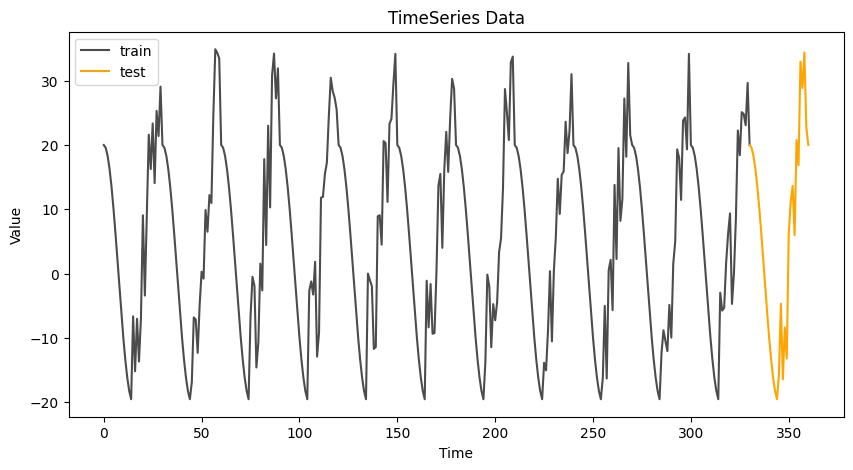

In [76]:
plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

In [77]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩
    x_train, y_train = list(), list()

    for i in range(len(time_series)):  #0
        x = time_series[i:(i + n)]      #0:0+n
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)

In [78]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 15)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] | 16
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] | 17
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] | 18


In [79]:
n = 15
x, y = make_sequence(time_series, n)
x.shape


(346, 15)

In [80]:
x_reshaped = x.reshape(-1, n, 1)
y_reshaped = y.reshape(-1, 1)

In [81]:
print(x_reshaped.shape)
print(y_reshaped.shape)

(346, 15, 1)
(346, 1)


In [82]:
x_train = x_reshaped[:30 * 11]
y_train = y_reshaped[:30 * 11]
x_test = x_reshaped[30 * 11:]
y_test = y_reshaped[30 * 11:]

print('train:', x_train.shape, y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (330, 15, 1) (330, 1)
test: (16, 15, 1) (16, 1)


## 1. SimpleRNN 구축

- tanh: Hyperbolic tangent 함수
- -1~1사이의 값, 출력범위가 sigmoid보다 크고, 경사가 큰 구간이 많아 sigmoid보다 빠르게 수렴하여 학습하는 특성
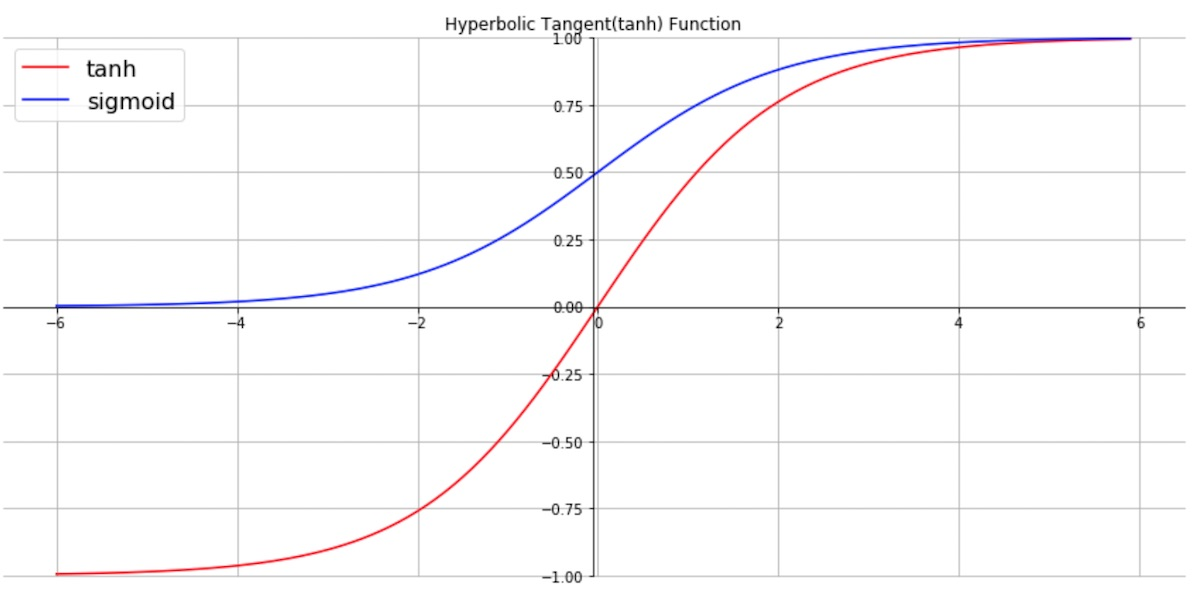

In [83]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
#model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.fit(x_train, y_train, epochs = 10, batch_size = 1)

Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 142.9391
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 76.7479
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.7227
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51.4480
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40.8908
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.1284
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.6517
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 34.9993
Epoch 9/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 38.0187
Epoch 10/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 28.6361


## 5. 예측 VS Actual


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


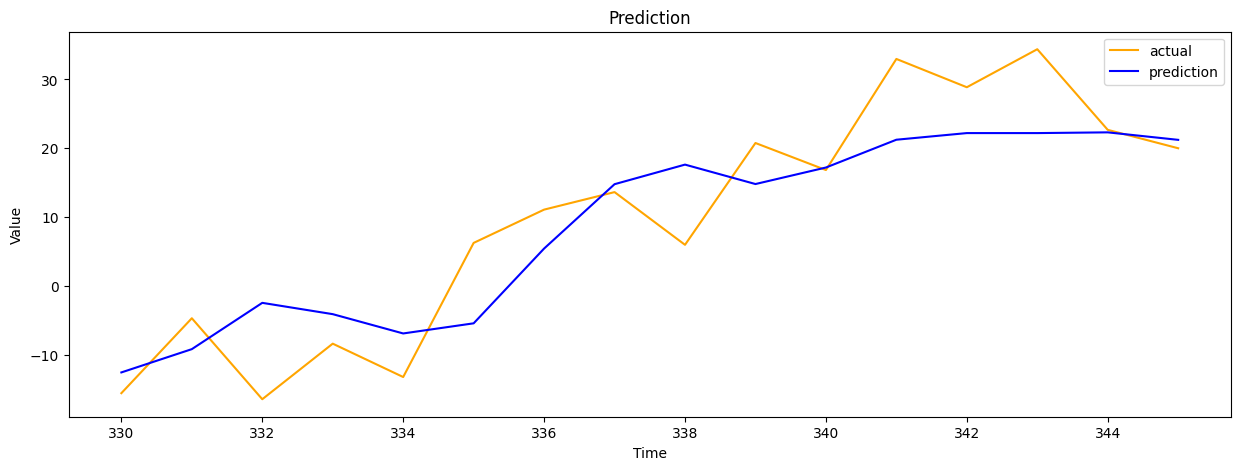

In [85]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

- 기온 데이터에 적용

In [86]:
#daily-min-temperature.csv
#n=10
#1~3600행은 train, 나머지 test
#RNN, ML 비교 (MSE로 비교)
#SimpleRNN, Dense, Dense......
import pandas as pd
data = pd.read_csv('daily-min-temperatures.csv', index_col=0)
data = data.values

n = 10
x, y = make_sequence(data, n)

X_train = x[0:3600, :]
X_test = x[3600:, :]

y_train = y[0:3600]
y_test = y[3600:]

X_train = X_train.reshape(-1, n, 1)
X_test = X_test.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [87]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.fit(X_train, y_train, epochs=10)
pred_rnn = model.predict(X_test)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 96.6460
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.3008
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14.5133
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.4252
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5670
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4685
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7141
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5490
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4757
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4652
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


- ML Regression

In [88]:
from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor()
model2.fit(X_train.reshape(-1, n), y_train)
pred_gb = model2.predict(X_test.reshape(-1, n))

In [89]:
from sklearn.metrics import mean_squared_error
y_test = y[3600:]
print(mean_squared_error( y_test, pred_rnn))
print(mean_squared_error( y_test, pred_gb))

4.646130228946779
4.27659808431441


# RNN 실습 2





In [129]:
import numpy as np
import pandas as pd
import yfinance as yf

AMZN = yf.download('AMZN', start="2022-01-01", end="2023-12-31")

AMZN = AMZN.round(2)
AMZN.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2022-01-03,170.40,170.40,170.70,166.16,167.55,63520000
2022-01-04,167.52,167.52,171.40,166.35,170.44,70726000
2022-01-05,164.36,164.36,167.13,164.36,166.88,64302000
2022-01-06,163.25,163.25,164.80,161.94,163.45,51958000
2022-01-07,162.55,162.55,165.24,162.03,163.84,46606000


In [130]:
AMZN['Adj Close'].values

array([[170.4 ],
       [167.52],
       [164.36],
       [163.25],
       [162.55],
       [161.49],
       [165.36],
       [165.21],
       [161.21],
       [162.14],
       [158.92],
       [156.3 ],
       [151.67],
       [142.64],
       [144.54],
       [139.99],
       [138.87],
       [139.64],
       [143.98],
       [149.57],
       [151.19],
       [150.61],
       [138.85],
       [157.64],
       [157.94],
       [161.41],
       [161.19],
       [159.  ],
       [153.29],
       [155.17],
       [156.51],
       [158.1 ],
       [154.65],
       [152.6 ],
       [150.2 ],
       [144.83],
       [151.36],
       [153.79],
       [153.56],
       [151.14],
       [152.05],
       [147.9 ],
       [145.64],
       [137.45],
       [136.01],
       [139.28],
       [146.82],
       [145.52],
       [141.85],
       [147.37],
       [153.1 ],
       [157.24],
       [161.25],
       [161.49],
       [164.89],
       [163.41],
       [163.65],
       [164.77],
       [168.99

In [131]:
n = 5
x, y = make_sequence(AMZN["Adj Close"].values, n)
x = x.reshape(-1, n, 1)
y = y.reshape(-1, 1)

In [132]:
print(x.shape)
print(y.shape)

(496, 5, 1)
(496, 1)


In [133]:
test_len = 440
x_train = x[:test_len]
y_train = y[:test_len]
x_test = x[test_len:]
y_test = y[test_len:]

print('train:', x_train.shape, y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (440, 5, 1) (440, 1)
test: (56, 5, 1) (56, 1)


## 2. SimpleRNN 구축

In [134]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
#model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(16, activation = 'relu'))
#rnn은 이전 단계의 가중치를 사용하며, relu 를 사용하면, 역전파 시 이전 단계의 그라디언트와 같이 사용되면 출력이 발산
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 32)                  │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.fit(x_train, y_train, epochs = 20, batch_size = 1)

Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 11031.2129
Epoch 2/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 677.1549
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 146.9563
Epoch 4/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40.7382
Epoch 5/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 30.4757
Epoch 6/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 25.8799
Epoch 7/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19.8970
Epoch 8/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22.5463
Epoch 9/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.3292
Epoch 10/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 21.8459
Epoch 11/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.3856
Epoch 12/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 21.9430
Epoch 13/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 19.1881
Epoch 14/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19.0205
Epoch 15/20
440/440 ━━━━━━━━━━━━━━━━━━

## 3. SimpleRNN 예측 VS Actual


In [136]:
pred = model.predict(x_test)
pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


array([[132.16693 ],
       [135.04361 ],
       [135.12164 ],
       [132.06345 ],
       [135.93414 ],
       [134.56467 ],
       [130.16904 ],
       [131.28867 ],
       [127.7216  ],
       [129.28992 ],
       [132.17854 ],
       [122.725266],
       [120.20078 ],
       [134.10635 ],
       [136.15797 ],
       [134.5162  ],
       [139.96266 ],
       [141.20276 ],
       [141.61838 ],
       [143.28322 ],
       [146.44296 ],
       [145.46535 ],
       [144.1322  ],
       [147.69464 ],
       [146.2702  ],
       [149.54701 ],
       [146.84988 ],
       [146.72287 ],
       [149.3513  ],
       [149.81421 ],
       [147.56183 ],
       [150.74316 ],
       [150.51651 ],
       [151.37167 ],
       [150.85733 ],
       [150.285   ],
       [150.16858 ],
       [151.00337 ],
       [148.75436 ],
       [150.91966 ],
       [148.45378 ],
       [150.84738 ],
       [151.21553 ],
       [149.63573 ],
       [151.45973 ],
       [152.54425 ],
       [151.10887 ],
       [153.6

In [137]:
mean_squared_error(y_test[0:50], pred[0:50])

16.208511801562093

In [138]:
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

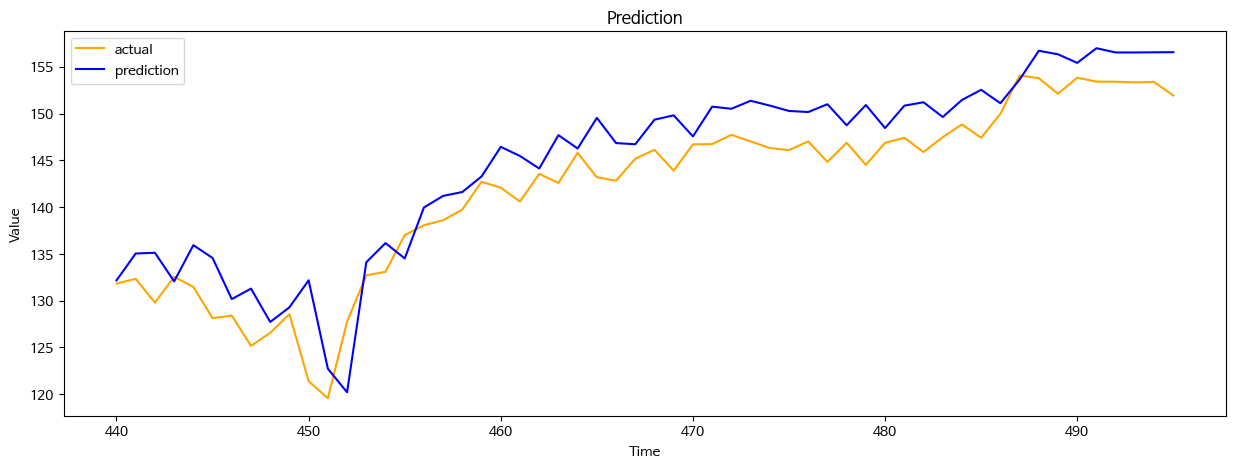

In [139]:
plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 4. LSTM 사용 및 예측 결과

In [140]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

LSTM_model = Sequential()
LSTM_model.add(LSTM(units = 50, activation = 'tanh', input_shape = (n, 1), return_sequences=True))
LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
LSTM_model.add(Dense(1, activation = 'linear'))

LSTM_model.compile(optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss = 'mse')  #mean squared error
LSTM_model.fit(x_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 12053.9824
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3964.0190
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2259.5466
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1367.6178
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1012.5491
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 878.7009
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 879.7299  
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 890.9164  
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 851.3638  
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 703.4285 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 666.2466 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 527.0525
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 509.6343
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 483.2681
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss:

In [141]:
pred = model.predict(x_test)
pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


array([[132.16693 ],
       [135.04361 ],
       [135.12164 ],
       [132.06345 ],
       [135.93414 ],
       [134.56467 ],
       [130.16904 ],
       [131.28867 ],
       [127.7216  ],
       [129.28992 ],
       [132.17854 ],
       [122.725266],
       [120.20078 ],
       [134.10635 ],
       [136.15797 ],
       [134.5162  ],
       [139.96266 ],
       [141.20276 ],
       [141.61838 ],
       [143.28322 ],
       [146.44296 ],
       [145.46535 ],
       [144.1322  ],
       [147.69464 ],
       [146.2702  ],
       [149.54701 ],
       [146.84988 ],
       [146.72287 ],
       [149.3513  ],
       [149.81421 ],
       [147.56183 ],
       [150.74316 ],
       [150.51651 ],
       [151.37167 ],
       [150.85733 ],
       [150.285   ],
       [150.16858 ],
       [151.00337 ],
       [148.75436 ],
       [150.91966 ],
       [148.45378 ],
       [150.84738 ],
       [151.21553 ],
       [149.63573 ],
       [151.45973 ],
       [152.54425 ],
       [151.10887 ],
       [153.6

In [142]:
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

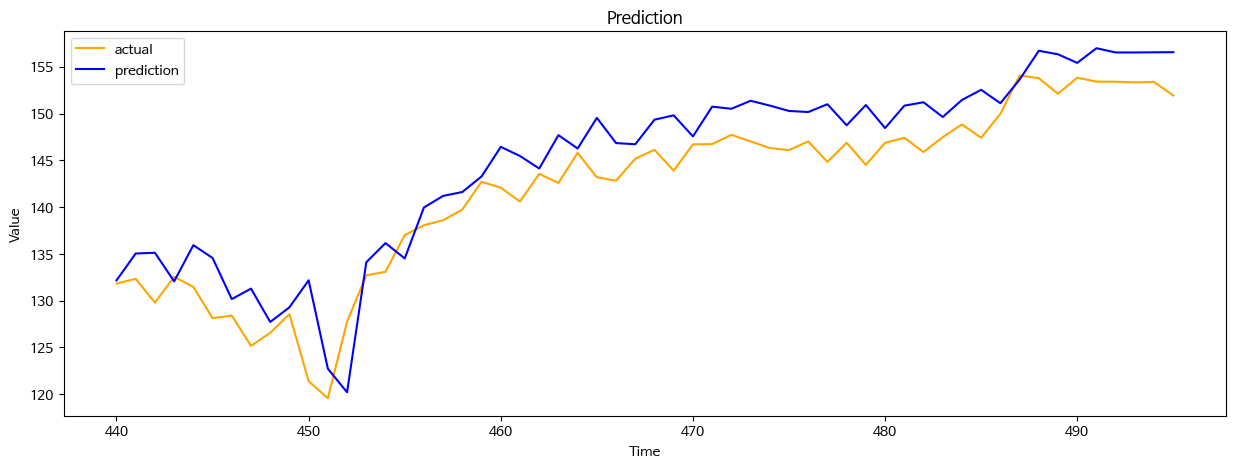

In [143]:
plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

- 국내 주가에 적용

In [144]:
#pykrx 설치하셔서 국내주가에 대해서 모델링
!pip install pykrx

In [145]:
from pykrx import stock
df = stock.get_market_ohlcv_by_date("20221201", "20241130", "005930")

In [146]:
sereis = df.종가.values
#scaling

X, y = make_sequence( sereis, 5)
X_train = X[0:420, :]
X_test = X[420:, :]
y_train  = y[0:420]
y_test = y[420:]

from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, pred1))

3240289.5692307693


In [147]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model2 = Sequential()
model2.add( Dense( 10, activation='relu', input_shape=(5,) ))
model2.add( Dense( 5, activation='relu' ))
model2.add( Dense( 1, activation="linear"))
model2.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model2.fit(X_train, y_train, epochs=30)
pred2 = model2.predict(X_test)
print(mean_squared_error(y_test, pred2))

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1537194624.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 923788672.0000  
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 462368000.0000 
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171053712.0000 
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40793552.0000  
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6204091.0000 
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2519064.5000  
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2793512.5000 
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2024562.0000 
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1948658.1250 
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2335366.2500
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2180548.2500  
Epoch 13/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2196699.5000 
Epoch 14/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

In [148]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
model3 = Sequential()
model3.add( LSTM( 10, activation='relu', input_shape=(5,1) ))
model3.add( Dense( 5, activation='relu' ))
model3.add( Dense( 1, activation="linear"))
model3.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model3.fit(X_train.reshape(-1,n,1), y_train.reshape(-1, 1), epochs=30)
pred3 = model3.predict(X_test.reshape(-1, n,1))
print(mean_squared_error(y_test, pred3))

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 5056796160.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5060911104.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5201598464.0000
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5179320832.0000
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5090454528.0000
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5103147520.0000
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5059030016.0000
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5075726848.0000
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5094987264.0000
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5105040384.0000
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5120458752.0000
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5091880960.0000
Epoch 13/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5088219136.0000
Epoch 14/30
14/14 ━━━━━━━━━━━━━━